## Impact of top-side TEC on SAR range delay

Dataset: Chile Sen asc track 149

+ Figure. Time-series of GIM/SUB/TOP_TEC and its predicted range delay for X/C/S/L-band SAR

In [1]:
%matplotlib inline
import os
import h5py
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt, ticker, dates as mdates, colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from tools.simulation import iono
plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'lines.linewidth': 2.0})
speed_of_light = 299792458 # speed of light in m / s

# location of interest
win = 9  # size of the window of interest where the median offset is calculated
lalo = [-21.29, -69.58]; box_suffix = 'boxCL'   # box in the center left with low  altitude; box = (10,  55,  20, 70) for SenAT149
lalo = [-21.30, -67.39]; box_suffix = 'boxLR'   # box in the lower right with high altitude; box = (200, 15, 215, 30) for SenAT149

# dir
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149')
proj_name = os.path.basename(proj_dir)

work_dir = os.path.join(proj_dir, 'offset_comp', box_suffix)
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR


## Figure - Ionospheric Impact on C-/S-/L-band SAR

### 1. Read data

In [2]:
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
tec_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/subTEC.h5')

# geometry
inc_angle = 42   # use the median value of NISAR
inc_angle_iono = iono.incidence_angle_ground2iono(inc_angle)

# TEC
tec_dict = {}
with h5py.File(tec_file, 'r') as f:
    tec_dict['TOP TEC'] = f['vtec_top'][:]
    tec_dict['SUB TEC'] = f['vtec_sub'][:]
    tec_dict['GIM TEC'] = f['vtec_gim'][:]

# time
date_list = timeseries(tec_file).get_date_list()
dates = ptime.date_list2vector(date_list)[0]

# stats
for key, value in tec_dict.items():
    print('{} min/max/span: {:.1f} / {:.1f} / {:.1f}'.format(key, np.nanmin(value), np.nanmax(value), np.nanmax(value)-np.nanmin(value)))

TOP TEC min/max/span: 3.3 / 11.5 / 8.1
SUB TEC min/max/span: 0.3 / 48.7 / 48.3
GIM TEC min/max/span: 6.6 / 59.1 / 52.5


### 2. Plot

number of TOP TEC: 93
  L min/max/span delay: 1.15 / 3.94 / 2.79 m
    8 TECU -> 0.4 pixels for L-band.
    8 TECU -> 0.8 pixels for L-band.
    8 TECU -> 1.5 pixels for L-band.
  S min/max/span delay: 0.18 / 0.61 / 0.43 m
    8 TECU -> 0.22 pixels for S-band.
  C min/max/span delay: 0.06 / 0.21 / 0.15 m
    8 TECU -> 0.06 pixels for C-band.
  X min/max/span delay: 0.02 / 0.07 / 0.05 m
    8 TECU -> 0.03 pixels for X-band.
number of SUB TEC: 93
  L min/max/span delay: 0.12 / 16.71 / 16.59 m
  S min/max/span delay: 0.02 / 2.58 / 2.56 m
  C min/max/span delay: 0.01 / 0.90 / 0.90 m
  X min/max/span delay: 0.00 / 0.28 / 0.28 m
save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/topTEC_pred.pdf


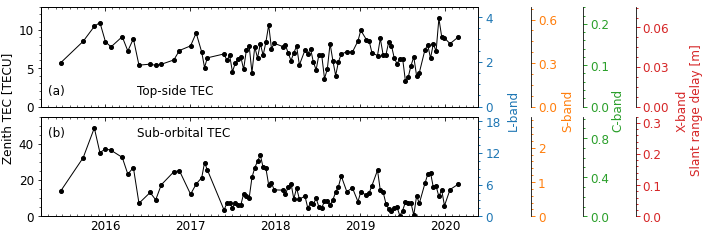

In [3]:
labels = ['Top-side TEC', 'Sub-orbital TEC']
ystepsDict = {
    'TOP TEC' : [2, 0.3, 0.1, 0.03],
    'SUB TEC' : [6, 1.0, 0.4, 0.10],
}
rg_bw_dict = {
    'S' : 75e6,
    'C' : 64.35e6,
    'X' : 109.89e6,
}
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[10, 3.5], sharex=True)
for i, (ax, tec_type, ymax, ystep) in enumerate(zip(axs, list(tec_dict.keys())[:2], [13, 55], [1, 5])):
    ts_tec = tec_dict[tec_type]
    # omit nan values
    flag = ~np.isnan(ts_tec)
    ts_tec = np.array(ts_tec)[flag]
    x = np.array(dates)[flag]
    print('number of {}: {}'.format(tec_type, np.sum(flag)))

    # plot
    ax.plot(x, ts_tec, '-o', label=tec_type, color='k', ms=4, lw=1)
    ax.tick_params(which='both', axis='x', direction='in', top=True, bottom=True)
    ax.set_ylim(0, ymax)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(ystep))

    # predicted range delay
    ysteps = ystepsDict[tec_type]
    for j, (bname, c) in enumerate(zip(iono.SAR_BAND.keys(), ['C0', 'C1', 'C2', 'C3'])):
        # calculate
        ts_delay = iono.vtec2range_delay(ts_tec, inc_angle=42, freq=iono.SAR_BAND[bname])
        dmin, dmax = np.nanmin(ts_delay), np.nanmax(ts_delay)
        print(f'  {bname} min/max/span delay: {dmin:.2f} / {dmax:.2f} / {dmax-dmin:.2f} m')

        # mis-registration
        if tec_type == 'TOP TEC':
            if bname == 'L':
                for rg_bw in [24e6, 44e6, 80e6]:
                    rg_delay_pix = (dmax - dmin) / (speed_of_light / rg_bw / 2)
                    print(f'    8 TECU -> {rg_delay_pix:.1f} pixels for L-band.')
            else:
                rg_bw = rg_bw_dict[bname]
                rg_delay_pix = (dmax - dmin) / (speed_of_light / rg_bw / 2)
                print(f'    8 TECU -> {rg_delay_pix:.2f} pixels for {bname}-band.')

        # add y-axis
        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', 1.0+0.12*j))
        ax2.tick_params(which='both', axis='y', colors=c, width=1)
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(ysteps[j]))
        ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

        # ylim sync btw. ax and ax2
        ratio = ((np.max(ts_delay) - np.min(ts_delay)) / (np.max(ts_tec)   - np.min(ts_tec)))
        ax2.set_ylim(np.array(ax.get_ylim()) * ratio)
        #ax2.plot(x, ts_delay, 'o', mfc='none')  # test

# axis format
pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=None)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)

# label
for ax, num, label, yloc in zip(axs, ['(a)', '(b)'], labels, [0.12, 0.8]):
    ax.annotate(num,   xy=(0.015, yloc), xycoords='axes fraction', ha='left')
    ax.annotate(label, xy=(0.220, yloc), xycoords='axes fraction', ha='left', color='k')
plt.annotate('Zenith TEC [TECU]', xy=(0.002, 0.55), xycoords='figure fraction', va='center', rotation='vertical')
for ylabel, xloc, color in zip(['L-band', 'S-band', 'C-band', 'X-band\nSlant range delay [m]'], [0.715, 0.79, 0.86, 0.96], ['C0', 'C1', 'C2', 'C3']):
    plt.annotate(ylabel, xy=(xloc, 0.54), color=color, xycoords='figure fraction', ha='center', va='center', rotation='vertical')

# output
out_fig = os.path.join(proj_dir, 'offset_comp/topTEC_pred.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 2. Plot - OLD

number of TOP TEC: 93
number of SUB TEC: 93
number of GIM TEC: 104
save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/topTEC_pred.pdf


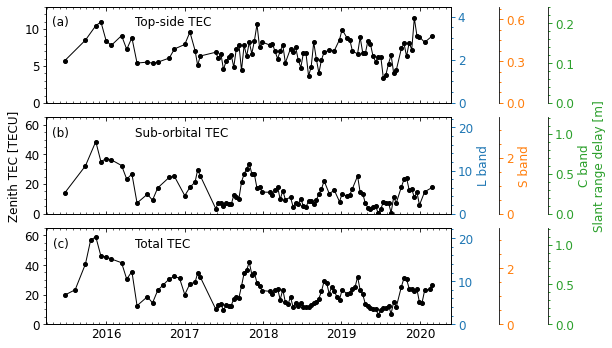

In [4]:
labels = ['Top-side TEC', 'Sub-orbital TEC', 'Total TEC']
ystepsDict = {
    'TOP TEC' : [2, 0.3, 0.1],
    'SUB TEC' : [10, 2, 0.5],
    'GIM TEC' : [10, 2, 0.5],
}
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[9, 5], sharex=True)
for i, (ax, tec_type, ymax, ystep) in enumerate(zip(axs, tec_dict.keys(), [13, 65, 65], [1, 5, 5])):
    ts_tec = tec_dict[tec_type]
    # omit nan values
    flag = ~np.isnan(ts_tec)
    ts_tec = np.array(ts_tec)[flag]
    x = np.array(dates)[flag]
    print('number of {}: {}'.format(tec_type, np.sum(flag)))

    # plot
    ax.plot(x, ts_tec, '-o', label=tec_type, color='k', ms=4, lw=1)
    ax.tick_params(which='both', axis='x', direction='in', top=True, bottom=True)
    ax.set_ylim(0, ymax)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(ystep))
    ax.annotate(labels[i], xy=(0.22, 0.8), xycoords='axes fraction', color='k', ha='left')

    # predicted range delay
    ysteps = ystepsDict[tec_type]
    for j, (bname, c) in enumerate(zip(iono.SAR_BAND.keys(), ['C0', 'C1', 'C2'])):
        # calculate
        ts_delay = iono.vtec2range_delay(ts_tec, inc_angle=42, freq=iono.SAR_BAND[bname])

        # add y-axis
        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', 1.0+0.12*j))
        ax2.tick_params(which='both', axis='y', colors=c, width=1)
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(ysteps[j]))
        ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

        # ylabel
        if i == 1:
            label = '{} band'.format(bname)
            label += '\nSlant range delay [m]' if j == 2 else ''
            ax2.set_ylabel(label, color=c)

        # ylim sync btw. ax and ax2
        ratio = ((np.max(ts_delay) - np.min(ts_delay)) / (np.max(ts_tec)   - np.min(ts_tec)))
        ax2.set_ylim(np.array(ax.get_ylim()) * ratio)
        ## test
        #ax2.plot(x, ts_delay, 'o', mfc='none')

# axis format
pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=None)
axs[1].set_ylabel('Zenith TEC [TECU]')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# label
for ax, label in zip(axs, ['(a)', '(b)', '(c)']):
    ax.annotate(label, xy=(0.055, 0.80), xycoords='axes fraction', ha='right')

# output
out_fig = os.path.join(proj_dir, 'offset_comp/topTEC_pred.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Figure - Percentage of TOP TEC

percentage min/max: 15 / 95
save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/topTEC_perc.pdf


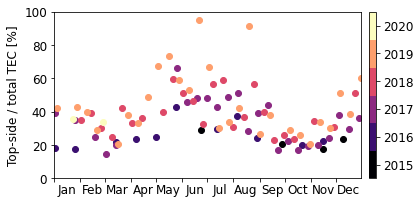

In [5]:
# prepare data
perc = tec_dict['TOP TEC'] / tec_dict['GIM TEC'] * 100
print('percentage min/max: {:.0f} / {:.0f}'.format(np.nanmin(perc), np.nanmax(perc)))

years = sorted(list(set([d.year for d in dates])))
num_year = len(years)
year0 = 2016

# plot
fig, ax = plt.subplots(figsize=[6, 3])
cmap = plt.get_cmap('magma', lut=num_year)
for i, year in enumerate(years):
    flag = np.array([d.year == year for d in dates], dtype=np.bool_)
    xs = np.array(dates)[flag]
    xs = [x.replace(year=year0) for x in xs]
    ax.plot(xs, perc[flag], 'o', c=cmap(i))

# axis format
ax.set_ylabel('Top-side / total TEC [%]')
ax.set_ylim(0, 100)
ax.set_xlim(dt.datetime(year0, 1, 1), dt.datetime(year0, 12, 31))
# centering labels beetween ticks (https://matplotlib.org/stable/gallery/ticks_and_spines/centered_ticklabels.html)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

# colorbar
cticks = (np.arange(num_year) + 0.5) / num_year
cax = make_axes_locatable(ax).append_axes('right', 0.1, pad=0.1, axes_class=plt.Axes)
cbar = colorbar.ColorbarBase(cax, cmap=cmap, ticks=cticks)
cbar.ax.set_yticklabels(years)

fig.tight_layout()
# output
out_fig = os.path.join(proj_dir, 'offset_comp/topTEC_perc.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()